## Business Problem

📌 Making production focused on home textiles and daily wear, which sells through Amazon, Kozmos aims to increase its sales by analyzing the comments received on its products and improving its features according to the complaints it receives. In line with this goal, comments will be tagged with sentiment analysis and a classification model will be created with the tagged data.

## Dataset Story
📌 The data set consists of the comments made for a certain product group, the title of the comment, the number of stars, and the variables that indicate how many people found the comment useful.

**Star**: Number of stars given to the product

**HelpFul**: Number of people who found the comment helpful

**Title**: Title given to comment content, short comment

**review**: Comment on the product


# Import Necessary Libraries

In [28]:
!pip install nltk
!pip install textblob
!pip install wordcloud

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Import Dataset

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/amazon_kozmos.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


# Text Processing

In [6]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [7]:
df = text_preprocessing(df, "Review")

In [8]:
df["Review"].head()

0                                                happy
1                  good quality material however panel
2    product fun bedroom windowsbr imagery bit stre...
3                              lo que e que un poco ma
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

# Text Visualization

In [9]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")

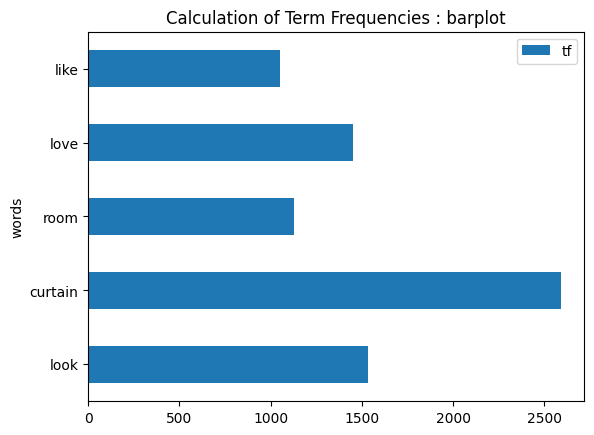

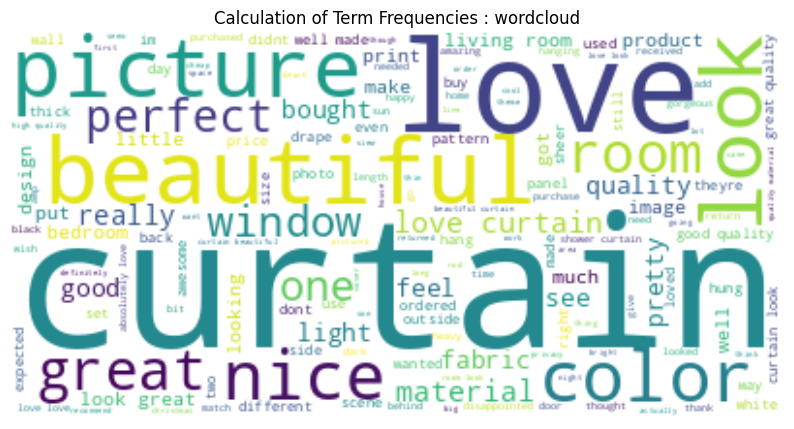

In [10]:
text_visulaization(df, "Review")

# Sentiment Analysis

In [11]:
def create_polarity_scores(dataframe, dependent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])

In [12]:
create_polarity_scores(df, "Review")

In [13]:
df.head()

,Star,HelpFul,Title,Review,polarity_score
0,5,0,looks great,happy,0.57
1,5,0,Pattern did not align between the two panels.,good quality material however panel,0.44
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72
3,5,0,Que se ven elegantes muy finas,lo que e que un poco ma,0.00
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90


# Feature Engineering

In [14]:
# Create Lables
def create_label(dataframe, dependent_var, independent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y

In [15]:
X, y = create_label(df, "Review", "sentiment_label")

In [16]:
# Split Dataset
def split_dataset(dataframe, X, y):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y

In [17]:
train_x, test_x, train_y, test_y = split_dataset(df, X, y)

In [43]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer().fit(train_x)
  x_train_count_vectorizer = vectorizer.transform(train_x)
  x_test_count_vectorizer = vectorizer.transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [44]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [41]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
  x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word

In [42]:
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [47]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3)).fit(train_x)
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram

In [48]:
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

In [49]:
def create_features_TFIDF_chars(train_x, test_x):
  # TF-IDF Characters
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,3)).fit(train_x)
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(train_x)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars

In [50]:
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

# Sentiment Modeling - Create Model

In [53]:
# Logistic Regression
def crate_model_logistic(train_x, test_x, test_y):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  log_model_count = LogisticRegression().fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(log_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  y_pred_count = log_model_count.predict(x_test_count_vectorizer)
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)
  print(classification_report(y_pred_count, test_y))

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  log_model_word = LogisticRegression().fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(log_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  y_pred_word = log_model_word.predict(x_test_tf_idf_word)
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)
  print(classification_report(y_pred_word, test_y))

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  log_model_ngram = LogisticRegression().fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(log_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  y_pred_ngram = log_model_ngram.predict(x_test_tf_idf_ngram)
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)
  print(classification_report(y_pred_ngram, test_y))

  # TF-IDF chars
  x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)
  log_model_chars = LogisticRegression().fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(log_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  y_pred_chars = log_model_chars.predict(x_test_tf_idf_chars)
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)
  print(classification_report(y_pred_chars, test_y))

  return log_model_count, log_model_word, log_model_ngram, log_model_chars

In [54]:
log_model_count, log_model_word, log_model_ngram, log_model_chars = crate_model_logistic(train_x, test_x, test_y)

Accuracy - Count Vectors: 0.904
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       177
           1       0.97      0.96      0.97      1226

    accuracy                           0.94      1403
   macro avg       0.85      0.89      0.87      1403
weighted avg       0.94      0.94      0.94      1403

Accuracy - TF-IDF Word: 0.864
              precision    recall  f1-score   support

           0       0.30      0.87      0.45        69
           1       0.99      0.90      0.94      1334

    accuracy                           0.90      1403
   macro avg       0.65      0.88      0.70      1403
weighted avg       0.96      0.90      0.92      1403

Accuracy TF-IDF ngram: 0.860
              precision    recall  f1-score   support

           0       0.02      0.50      0.04         8
           1       1.00      0.86      0.92      1395

    accuracy                           0.86      1403
   macro avg       0.51      0.68    

In [57]:
# Random Forest
def crate_model_randomforest(train_x, test_x, test_y):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier().fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  y_pred_count = rf_model_count.predict(x_test_count_vectorizer)
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)
  print(classification_report(y_pred_count, test_y))

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_model_word = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  y_pred_word = rf_model_word.predict(x_test_tf_idf_word)
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)
  print(classification_report(y_pred_word, test_y))

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier()
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  y_pred_ngram = rf_model_ngram.predict(x_test_tf_idf_ngram)
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)
  print(classification_report(y_pred_ngram, test_y))

  # TF-IDF chars
  x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)
  rf_chars = RandomForestClassifier()
  rf_model_chars = rf_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(rf_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  y_pred_chars = rf_model_chars.predict(x_test_tf_idf_chars)
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)
  print(classification_report(y_pred_chars, test_y))

  return rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars

In [58]:
rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars = crate_model_randomforest(train_x, test_x, test_y)

Accuracy - Count Vectors: 0.907
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       169
           1       0.97      0.95      0.96      1234

    accuracy                           0.93      1403
   macro avg       0.82      0.87      0.84      1403
weighted avg       0.93      0.93      0.93      1403

Accuracy - TF-IDF Word: 0.894
              precision    recall  f1-score   support

           0       0.56      0.78      0.65       142
           1       0.97      0.93      0.95      1261

    accuracy                           0.92      1403
   macro avg       0.77      0.86      0.80      1403
weighted avg       0.93      0.92      0.92      1403

Accuracy TF-IDF ngram: 0.860
              precision    recall  f1-score   support

           0       0.17      0.77      0.27        43
           1       0.99      0.88      0.93      1360

    accuracy                           0.88      1403
   macro avg       0.58      0.82    

# Model Tuning

In [59]:
def model_tuning_randomforest(train_x, test_x, test_y):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier(random_state=1)
  rf_params = {"max_depth": [2,5, None],
               "max_features": [2,5, "auto"],
               "n_estimators": [100,500],
               "min_samples_split": [2,5]}
  rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=10, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
  rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=10).mean()
  y_pred_count = rf_model_count_final.predict(x_test_count_vectorizer)
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)
  print(classification_report(y_pred_count, test_y))

  return rf_model_count_final

In [60]:
rf_model_count_final = model_tuning_randomforest(train_x, test_x, test_y)

Accuracy - Count Vectors: 0.903
              precision    recall  f1-score   support

           0       0.67      0.79      0.72       168
           1       0.97      0.95      0.96      1235

    accuracy                           0.93      1403
   macro avg       0.82      0.87      0.84      1403
weighted avg       0.93      0.93      0.93      1403



# Prediction

In [61]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Pozitive")
  else:
    print("Comment is Negative")

In [66]:
# Logistic Regression
predict_count(train_x, model=log_model_count, new_comment="this product is good :)")

Comment is Pozitive


In [68]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="this product is very bad :)")

Comment is Negative


In [64]:
# Sample Review
new_comment=pd.Series(df["Review"].sample(1).values)
new_comment

0    beautiful curtain well made
dtype: object

In [65]:
# Sample Review - Random Forest
predict_count(train_x, model=rf_model_count, new_comment=new_comment)

Comment is Pozitive
